#### Propensity Weighting

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("ggplot")
import statsmodels.formula.api as smf
import matplotlib
from cycler import cycler

color=['0.2', '0.6', '1.0']
default_cycler = (cycler(color=color))
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']


plt.rc('axes', prop_cycle=default_cycler)

#### Adjusting with Regression

A company decided to invest in management training for its new managers. To measure effectiveness of training, company tried to randomly select managers into this program. The idea was to compare engagement score for employees whose managers got enrolled in the program with the engagement of those whose managers didn't. With proper randomization, this simple comparison would give the average treatment effect of the training.

Unfortunately, some managers who were assigned the training didn't want to go; others got the training without being assigned to receive it. The result is that a randomized study ended up being an observational study. People not getting the treatment they are intended to is called non-compliance.

In the data below, the treatment variable is intervention and the outcome of interest is engagement_score, which is the average standardized engagement score for that manager's employees. 

First, we start with using regression to adjust for the confounders as a benchmark.

$engagement_i=\tau T_i + \theta X_i + e_i$

We build a first model with only the treatment and then a second model where we include the confounders. The effect estimate is lower in the second model which is an indication of positive bias, meaning that managers whose employees were already more engaged are more likely to have participated in the training program. (The standard error is also slightly improved).

In [3]:
df = pd.read_csv('data/management_training.csv')
df.head()

,departament_id,intervention,engagement_score,tenure,n_of_reports,gender,role,last_engagement_score,department_score,department_size
0,76,1,0.277359,6,4,2,4,0.614261,0.224077,843
1,76,1,-0.449646,4,8,2,4,0.069636,0.224077,843
2,76,1,0.769703,6,4,2,4,0.866918,0.224077,843
3,76,1,-0.121763,6,4,2,4,0.029071,0.224077,843
4,76,1,1.526147,6,4,1,4,0.589857,0.224077,843


In [4]:
# initial model without adjusting for confounders
import statsmodels.formula.api as smf 

smf.ols("engagement_score ~ intervention", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.2347,0.014,-16.619,0.000,-0.262,-0.207
intervention,0.4346,0.019,22.616,0.000,0.397,0.472


In [5]:
model = smf.ols("""engagement_score ~ intervention
            + tenure + last_engagement_score + department_score
            + n_of_reports + C(gender) + C(role)""", data=df).fit()

print("ATE: ", model.params["intervention"])
print("95% CI: ", model.conf_int().loc["intervention", :].values.T)

ATE:  0.26779085766768596
95% CI:  [0.23357751 0.30200421]


#### Propensity Score

Propensity weighting is a technique that involves modeling the treatment assignment mechanisim and using the model's prediction to reweight the data, instead of building residuals like in orthogonalization. Propensity weighting revolves around the concept of a propensity score, which itself comes from the realization that, you don't need to directly control for confounders X to achieve conditional independence $(Y_1,Y_0)⊥T|X$.  It is sufficient to control for a balancing score that estimates E[T|X], which is often the P(T|X), called the propensity score, $e(x)$.

The propensity score can be viewed as a dimensionality reduction technique. Instead of conditioning on X, which can be very high dimensional, you can simply condition on the propensity score to block backdoor paths that flow through X: $(Y_1,Y_0)⊥T|P(x)$. The propensity score is the conditional probability of receiving the treatment, which is some sort of function that converts X into the treatment T. The propensity score makes this middle ground between the variable $X$ and the treatment $T$. If you know $e(x)$, X alone gives you no further information about $T$, which means controlling for $e(x)$ works the same way as controlling for X directly. Given the same propensity score, treatment is as good as random.

In the case of conditionally random experiment, true propensity score $e(x)$ is known because assingment mechanism is nondeterministic, but known. In most cases, assignment mechanism is unknown, so need to replace true propensity score by an estimation of $e(x)$. For binary treatment, logistic regression can be used to estimate e(x) (logistic regression of the treatment on the confounders).

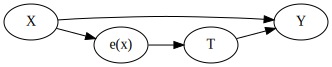

In [6]:
g = gr.Digraph(graph_attr={"rankdir": "LR"})
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "e(x)")
g.edge("e(x)", "T")

g

In [7]:
# estimating propensity score using logistic regression
ps_model = smf.logit("""intervention ~ tenure + last_engagement_score + department_score 
                     + C(n_of_reports) + C(gender) + C(role) """, data=df).fit(disp=0)

In [8]:
# saving estimated propensity score in a data frame
data_ps = df.assign(
    propensity_score = ps_model.predict(df), # initialized model able to pull out the cols needed and only those
)

data_ps[['intervention', 'engagement_score', 'propensity_score']].head() # treatment, outcome, propensity_score

,intervention,engagement_score,propensity_score
0,1,0.277359,0.596106
1,1,-0.449646,0.391138
2,1,0.769703,0.602578
3,1,-0.121763,0.580990
4,1,1.526147,0.619976


#### Propensity Score and Orthogonalization

In FLW theorem, linear regression does something similar to estimating a propensity score. In the debiasing step, it estimates $E[T|X]$. So, like propensity score estimation, OLS is modeling treatment assignment mechanism. This means you can also use propensity score $\hat e(X)$ inside a linear regression to adjust for the confounders X ie $E[Y|T,\hat e(X)]$. The estimated ATE with this approach is similar to the one obtained by fitting a linear model with the treatment and confounder X, $E[Y|T,X]$, as both approaches are simply orthogonalizing the treatment. The only difference is that $OLS$ uses linear regression to model $T$, while propensity score estimate was obtained from a logistic regression.

In [9]:
model = smf.ols("engagement_score ~ intervention + propensity_score", data=data_ps).fit()
model.params["intervention"]

0.26331267490277277

#### Propensity Score Matching

Another popular approach to control for propensity score is the matching estimator. This method searches for pairs of units with similar observable characteristics and compares the outcomes of those who received the treatment to those who did not. Matching is like a simple K-Nearest-Neighbors (KNN) algorithm, where K=1. 

- Fit a KNN model on the treated units, using propensity score as the only feature, use it to impute $Y_1$ for the control group. 
- Next fit a KNN on the untreated units and use it to impute $Y_0$ for the treated units. 
- In both cases, the imputed value is simply the outcome of the matched unit, where the match is based on the propensity score.

Once you have a match for each unit, you can estimate the ATE:

$\widehat {ATE} = \frac{1}{N}\Sigma [(Y_i - Y_{jm}(i))T_i + (Y_{jm}(i)-Y_i)(1-T_i)]$

where $Y_{jm}(i)$ is the match of unit $i$ from the treatment group different from $i's$ treatment group. This function reduces to the average difference in the potential outcome if treated and potential outcome if untreated, with either potential outcome the result of a match opposite to $i's$ treatment group. 

The matching estimator is biased, its variance is difficult to derive, and KNN is very inefficient with high dimensionality. You don't even need to use propensity score when matching. You could directly match on the raw features X used to construct the propensity score estimate $\hat P(T|X)$.

In [10]:
from sklearn.neighbors import KNeighborsRegressor 

T = "intervention"                          # treatment
X = "propensity_score"                      # propensity score captures the confounder effect
Y = "engagement_score"                      # outcome

treated = data_ps.query(f"{T}==1")          # filter treated units to yield dataframe
untreated = data_ps.query(f"{T}==0")        # filter untreated units to yield dataframe

mt0 = KNeighborsRegressor(n_neighbors=1).fit(untreated[[X]],    # initialize object with n_neighbors
                                             untreated[Y])      # fit to untreated data features and outcome 

mt1 = KNeighborsRegressor(n_neighbors=1).fit(treated[[X]],      # initialize object with n_neighbors
                                             treated[Y])        # fit to treated data features and outcome  

predicted = pd.concat([ 
    # find matches for the treated looking at untreated knn model for the potential outcome if untreated, Y_0
    treated.assign(match=mt0.predict(treated[[X]])), # model used features, could have used propensity score

    # find matches for the untreated looking at treated knn model for the potential outcome if treated, Y_1
    untreated.assign(match=mt1.predict(untreated[[X]])) # model used features, could have used propensity score
])  # concatenate treated and untreated dataframes after imputing potential outcomes
predicted.head()

,departament_id,intervention,engagement_score,tenure,n_of_reports,gender,role,last_engagement_score,department_score,department_size,propensity_score,match
0,76,1,0.277359,6,4,2,4,0.614261,0.224077,843,0.596106,0.557680
1,76,1,-0.449646,4,8,2,4,0.069636,0.224077,843,0.391138,-0.952622
2,76,1,0.769703,6,4,2,4,0.866918,0.224077,843,0.602578,-0.618381
3,76,1,-0.121763,6,4,2,4,0.029071,0.224077,843,0.580990,-1.404962
4,76,1,1.526147,6,4,1,4,0.589857,0.224077,843,0.619976,0.000354


In [11]:
# estimate ATE using propensity score matching
np.mean((predicted[Y] - predicted["match"])*predicted[T] +      # treatment is binary
        (predicted["match"] - predicted[Y])*(1-predicted[T]))   # estimate ite and average for ate

0.28777443474045966

#### Inverse Propensity Weighting

A third approach for utilizing propensity scores is the inverse propensity weighting (IPW). By reweighting the data based on the inverse probability of treatment, this method can make the treatment appear to be randomly assgined in the reweighted data. We reweight the sample by $1/P(T=t|X)$ in order to create a pseudo-population that approximates what would have happened if everyone had received the treatment $t$:

$E[Y_t]=E[\frac{１(T=t)Y}{P(T=t|X)}]$ where １(T=t)Y yields 1 if T=t otherwise 0.

Say we want to know the expectation of $Y_1$, the average engagement, had all managers taken the training. We would take all those who were treated and scale them by the inverse probability of getting the treatment. This puts a high weight on those with very low probability of treatment, but nonetheless got it, essentially up-weighting rare treatment examples. The intuition is that if a treated individual has a low probability of treatment, that individual looks a lot like the untreated. This treated unit that looks like the untreated will probably be very informative of what would happen to the untreated, had they been treated, $Y_1|T=0$. Same thing for the control. If a control unit looks a lot like the treated group, it is probably a good estimate for $Y_0|T=1$, so you give it more weight.

Then if you can use the propensity score to recover the average potential outcome, it also means you can use it to recover the ATE.

$ATE = E[\frac{１(T=1)Y}{P(T=1|X)}] - E[\frac{１(T=0)Y}{P(T=0|X)}]$  

$ATE = E[Y \frac{T-e(x)}{e(x)(1-e(x))}]$

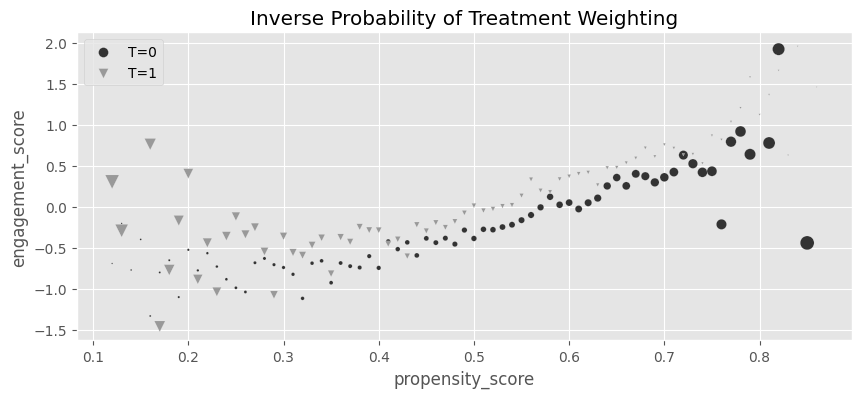

In [12]:
g_data = (data_ps
          .assign( # since propensity score is estimated with logistic regression the values here are P(T=1|X)
              weight=data_ps["intervention"]/data_ps["propensity_score"] +     # intervention is 1 or 0
                    (1-data_ps["intervention"])/(1-data_ps["propensity_score"]), # for t=0, P(T=0|X)=1-P(T=1|X)
              propensity_score=data_ps["propensity_score"].round(2)
          )
          .groupby(["propensity_score", "intervention"])
          [["weight", "engagement_score"]]
          .mean()   # for each intervention and for each propensity_score, representative weight/outcome is avg 
          .reset_index())

plt.figure(figsize=(10,4))
for t in [0,1]: # for each intervention (treatment) propensity vs engagement, sizes based on weight
    sns.scatterplot(data=g_data.query(f"intervention=={t}"), y="engagement_score",
                    x="propensity_score", size="weight", 
                    sizes=(1,100), color=color[t], legend=None, label=f"T={t}", marker=marker[t])
plt.title("Inverse Probability of Treatment Weighting")
plt.legend()

In [13]:
# using inverse propensity weighting to estimate causal effect
weight_t = 1 / data_ps.query("intervention==1")["propensity_score"]  # inverse propensity weights for treated
weight_nt = 1/(1-data_ps.query("intervention==0")["propensity_score"]) # ipw for untreated (get P(T=0|X) first)
t1 = data_ps.query("intervention==1")["engagement_score"]       # observed outcome for the treated
t0 = data_ps.query("intervention==0")["engagement_score"]       # observed outcome for the untreated    

y1 = sum(t1*weight_t)/len(data_ps)      # estimate average treated potential outcome using treated samples only
y0 = sum(t0*weight_nt)/len(data_ps)     # estimate average untreated potential outcome with untreated samples 

print("E[Y1]: ", y1)
print("E[Y0]: ", y0)
print("ATE: ", y1-y0)

E[Y1]:  0.1165631723294695
E[Y0]:  -0.1494155364781463
ATE:  0.26597870880761576


In [14]:
# simplified causal effect calculation using inverse propensity weighting
np.mean(data_ps["engagement_score"]
        * (data_ps["intervention"] - data_ps["propensity_score"])
        / (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

0.26597870880761587

#### Variance of IPW

Computing the standard error of IPW is not as straight forward as with linear regression. The most straightforward way to obtain confidence interval around your IPW estimate is by using the bootstrap method, where you repeatedly resample the data with replacement to obtain multiple IPW estimators. Then you can calculate the 2.5th and 97.5th percentiles of these estimates to obtain a 95% confidence interval.

The variance in the propensity score estimator will be large if you have big weights. Big weights means that some units have a big impact in the final estimate (since they are far from the mean and their individual weights are large). You'll have big weights if you have few control units in the region with high propensity or a few treated units in the region with low propensity score (where propensity score is defined as $\hat P(T=1|X)$, so low values when $T=1$ or high values when $T=0$ because $P(T=0|X) = 1-P(T=1|X)$). This will cause you to have few units to estimate the counterfactuals $Y_0|T=1$ and $Y_1|T=0$.

In [15]:
from sklearn.linear_model import LogisticRegression # sklearn LogisticRegression faster than statsmodels logit
from patsy import dmatrix                           # for convenience of R-style formula used in statsmodels

# define function that computes the IPW estimator
def est_ate_with_ps(df, ps_formula, T, Y):
    X = dmatrix(ps_formula, df)                     # engineers a feature matrix based on an R-style formula
    ps_model = LogisticRegression(penalty=None,     # note that no regularization
                                  max_iter=1000).fit(X, df[T]) # logistic regression iterations increase
    ps = ps_model.predict_proba(X)[:,1]             # store P(T=1|X)

    # compute the ATE
    return np.mean((df[T]-ps)/(ps*(1-ps))*df[Y])    # simplified ATE calculation from IPWs (div before prod)

In [16]:
formula = """tenure + last_engagement_score + department_score
+ C(n_of_reports) + C(gender) + C(role)"""  # formula contains only confounders for feature matrix
T = "intervention"                          # treatment for propensity score estimation 
Y = "engagement_score"                      # outcome for ATE estimation using inverse propensity weighting

est_ate_with_ps(df, formula, T, Y)

0.2660335522535528

In [17]:
# define bootstrap procedure
from joblib import Parallel, delayed    # for parallel processing

def  bootstrap(data, est_fn, rounds=200, seed=123, pcts=[2.5, 97.5]):
    np.random.seed(seed)

    stats = Parallel(n_jobs=-1)(
        delayed(est_fn)(data.sample(frac=1, replace=True))
        for _ in range(rounds)
    )
    return np.percentile(stats, pcts)

In [18]:
from toolz import partial 

In [19]:
# partial takes in a function and some of its arguments and returns another function with initial arguments
def addNumber(x, number):
    return x + number 

add2 = partial(addNumber, number=2)     # partially define addNumber with some arguments
add4 = partial(addNumber, number=4)

print(add2(3))
print(add4(3))

5
7


In [20]:
print(f"ATE: {est_ate_with_ps(df, formula, T, Y)}")

est_fn = partial(est_ate_with_ps, ps_formula=formula, T=T, Y=Y) # partial handles df for the ate function
print(f"95% C.I: ", bootstrap(df, est_fn))

ATE: 0.2660335522535528
95% C.I:  [0.22661673 0.30075822]


#### Stabilized Propensity Weights

Weighting the treated samples by $1/P(T=1|X)$ creates a pseudo-population the same size as the original one, as though everyone was treated. Likewise weighting the control by $1/P(T=0|X)$ creates a pseudo-population that behaves as though everyone had the control. This means the sum of the treated weights or the control weights is about the same as the original sample size. From an importance sampling point of view, you are taking data that came from $P(T=1|X)$, which is biased if X also causes Y, and reconstructing $P(T=1)=1$, where treatment probability does not depend on X.

This is fine as long as the weights are not too large. But if the treatment is very unlikely, $P(T|X)$ can be tiny making $1/P(T|X)$ very large which might cause some computational issues. A simple solution is to stabilize the weights using the marginal probability of treatment, $P(T=t)$.

$w=\frac{P(T=t)}{P(T=t|X)}$

With these weights, a treatment with low probability won't have massive weights because the small denominator will be balanced by the also small numerator. This won't change the results, but it is more compuationally stable. Stabilized weights reconstruct a pseudo-population where the effective size (sum of the weights) of both treated and control matches that of the original treated and control groups, respectively. From an importance sampling, point of view, with stabilized weights, you are coming from a distribution where the treatment depends on X, P(T=t|X), but reconstructing the marginal P(T=t). This stabilization keeps the same balancing properties of the original propensity score, yielding the exact same ATE estimate.

In [21]:
print("Original Sample Size", data_ps.shape[0])
print("Treated Pseudo-Population Sample Size", sum(weight_t))
print("Untreated Pseudo-Population Sample Size", sum(weight_nt))

Original Sample Size 10391
Treated Pseudo-Population Sample Size 10435.089079197904
Untreated Pseudo-Population Sample Size 10354.298899788299


In [22]:
p_of_t = data_ps["intervention"].mean()  # proportion of treated, marginal probability P(T=1)

t1 = data_ps.query("intervention==1")
t0 = data_ps.query("intervention==0")

weight_t_stable = p_of_t / t1["propensity_score"]           # stabilized weeighting, treatment and propensity 
weight_nt_stable = (1-p_of_t)/(1-t0["propensity_score"])    # probability of control / propensity of control

print("Treat size: ", len(t1))
print("W treat ", sum(weight_t_stable))

print("Control size: ", len(t0))
print("W treat", sum(weight_nt_stable))

Treat size:  5611
W treat  5634.807508745969
Control size:  4780
W treat 4763.116999421412


In [23]:
# verify stabilization yields same ATE as unweighted propensity score
nt = len(t1)            # for expected treated potential outcome below
nc = len(t0)            # for expected untreated potential outcome below

#y1 = np.average(t1["engagement_score"], weights=weight_t_stable)
#y0 = np.average(t0["engagement_score"], weights=weight_nt_stable)
y1 = sum(t1["engagement_score"]*weight_t_stable)/nt     # instead of len(t1) could use sum(weight_t_stable)
y0 = sum(t0["engagement_score"]*weight_nt_stable)/nc    # instead of len(t0) could use sum(weight_nt_stable)
print("ATE: ", y1 - y0)

ATE:  0.26597870880761565


#### Pseudo-Populations

How IPW uses pseudo-populations to remove bias, can be explained from the perspective of $P(T|X)$. If treatment was randomly assigned, the treatment would not depend on X ie $P(T|X)=P(T)$. If the treatment is independent from X, you would not have confounding bias flowing through X, and no adjustment would be needed. 

If you have bias, some units would have a higher chance of getting of getting the treatment. If you plot the distribution of $\hat e(X)$ by treatment status, since units don't have the same chance of treatment (ie not random), treated units will have higher $\hat e(X)$, as shown in the plot below on the left, where treated distribution for $\hat e(X)$ is a bit shifted to the right.

With IPW as show in the plot below on the right, in the low $\hat e(X)$ region, treated units are up-weighted and control units are down-weighted. Similarly when $\hat e(X)$ is high, treated units are down-weighted and control, up-weighted. These make the two distributions overlap, meaning that on the weighted data, treated and control have the same chance of getting both the treatment or the control ie treatment assignment looks as good as random (assuming no unobserved confounders). For the treated, IPW is trying to figure out from $Y|T=1$, what $Y_1|T=0$ would look like. Similarly for the control, IPW is trying to learn $Y_0|T=1$ by reweighting by $1/(1-P(T=1))$.

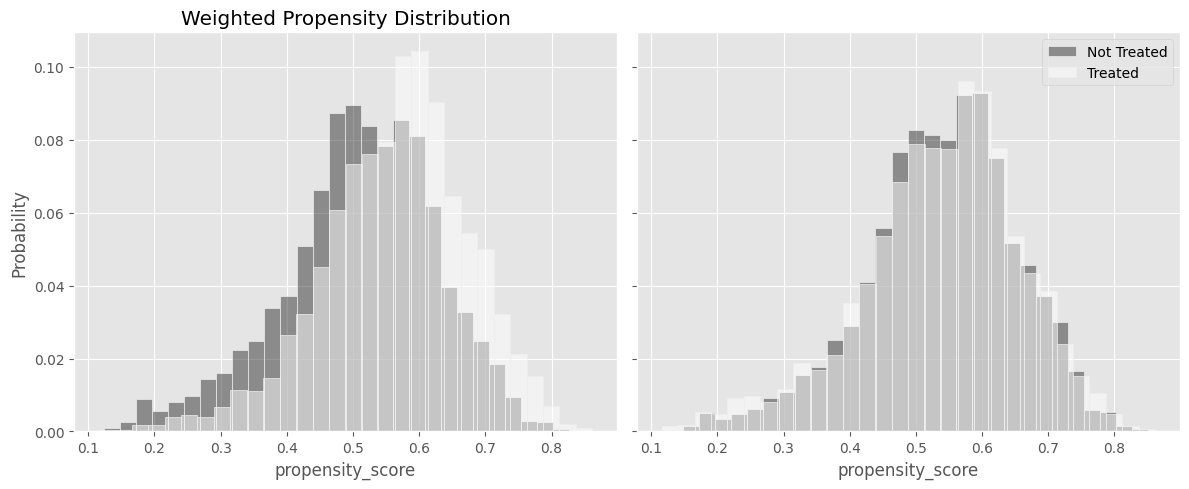

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True) # sharex will duplicate x

sns.histplot(data_ps.query("intervention==0")["propensity_score"], stat="probability",
            label="Not Treated", color="C0", bins=30, ax=ax1, alpha=0.5)
sns.histplot(data_ps.query("intervention==1")["propensity_score"], stat="probability",
            label="Treated", color="C2", bins=30, ax=ax1, alpha=0.5)
ax1.set_title("Propensity Distribution")

sns.histplot(data_ps.query("intervention==0").assign(w=weight_nt_stable), 
            x="propensity_score", stat="probability", weights="w",
            label="Not Treated", color="C0", bins=30, ax=ax2, alpha=0.5) # propensity score distribution

sns.histplot(data_ps.query("intervention==1").assign(w=weight_t_stable), 
            x="propensity_score", stat="probability", weights="w",
            label="Treated", color="C2", bins=30, ax=ax2, alpha=0.5) # ipw propensity score distribution
ax1.set_title("Weighted Propensity Distribution")
plt.legend()
plt.tight_layout()


#### Selection Bias

Propensity score weighting can be used for common causes (confounding bias) to make treatment similar to the control and vice versa. IPW can also be used to adjust for selection issues. Say you want to know the satisfaction of customers with an app, so you send out surveys asking to rate the app. Some customers don't respond, and this can bias your analysis. If the nonrespondents are mostly unsatisfied customers, the result from the survey will be an artificially inflated rate. To adjust, you can estimate the probability of responding, R, given customer's covariates (like age, income, app usage, etc.), P(R=1|X). Using IPW, you can reweight those who responded by $1/\hat P(R=1)$. This will up-weight the respondents that look like the nonrespondents (have low $\hat P(R=1)$). With this, an individual who answered will not only account for himself, but for other individuals like him, creating a pseudo-population as if everyone responded to the survey.

Sometimes, there is both confounding and selection bias together. In this case, you can use the product of the weights for both selection and confounding, stabilizing the confounding bias weights with the marginal probability P(T=t).

$W= \frac {\hat P(T=t)}{\hat P(R=1|X) \hat P(T=t|X)}$

#### Bias-variance trade-off

If you have a covariate $X_k$ that is a very good predictor of assignment but not the outcome, it will improve the accuracy of $e(x)$ but increase the variance of the IPW estimator. A good model of $e(X)$ will output high propensity values for all treated units but low values for all control units. This leaves no treated units with low $e(X)$ to estimate $Y_1|T=0$ and no control units with high $e(X)$ to estimate $Y_0|T=1$. However if treatment were random, $e(X)$ would have no predictive power. In otherwords, the more precise the propensity score model, the lower the bias, but if the propensity score model is too precise, the variance of the effect estimate increases.

#### Positivity

The bias-variance trade-off can be viewed in the light of two causal inference assumptions: conditional independence (unconfoundedness) and positivity. The more precise you make your model for $e(x)$, by adding more variables to it, the more you make the conditional independence assumption (CIA) hold. However, you also make positivity less plausible because you'll concentrate the treatment in low $e(x)$ region, far away from the controls and concentrate the controls in the high $e(x)$ region, far away from the treatment. This is because the added covariates helps the model be more confident in drawing the decision boundary between treated and control.

IPW reconstruction is only possible if you have samples to reweight. If there are no treated samples in the regionof low propensity score (high chance of being the control), reweighting will not reconstruct $Y_1$ in that region. This is positivity violation in terms of IPW. Even if positivity is not entirely violated, but a few units have very small or very large propensity scores, IPW will suffer from high variance.

A high-variance and positivity violations will make it so IPW cannot recover ATE estimation. Plotting the propensity scores of the IPW estimator will show these positivity violations. Regression on the other hand, extrapolates where you have no data whatsoever. If a linear model is a good fit for the conditional expectation, it will manage to recover the ATE even in regions where positivity doesnt hold. IPW makes no assumptions on the shape of the potential outcome; as such it fails in situations where extrapolation is needed.


In [25]:
np.random.seed(1)

n = 1000
x = np.random.normal(0,1,n)             # n values from standard normal
t = np.random.normal(x, 0.5, n) > 0     # higher the X val, the higher the chance of receiving treatment

y0 = -x                                 # potential outcome if control
y1 = y0 + t   # ate of 1                # potential outcome if treated

y = np.random.normal((1-t)*y0 + t*y1, 0.2)
df_no_pos = pd.DataFrame(dict(x=x, t=t.astype(int), y=y))
df_no_pos.head()

,x,t,y
0,1.624345,1,-0.526442
1,-0.611756,0,0.659516
2,-0.528172,0,0.438549
3,-1.072969,0,0.950810
4,0.865408,1,-0.271397


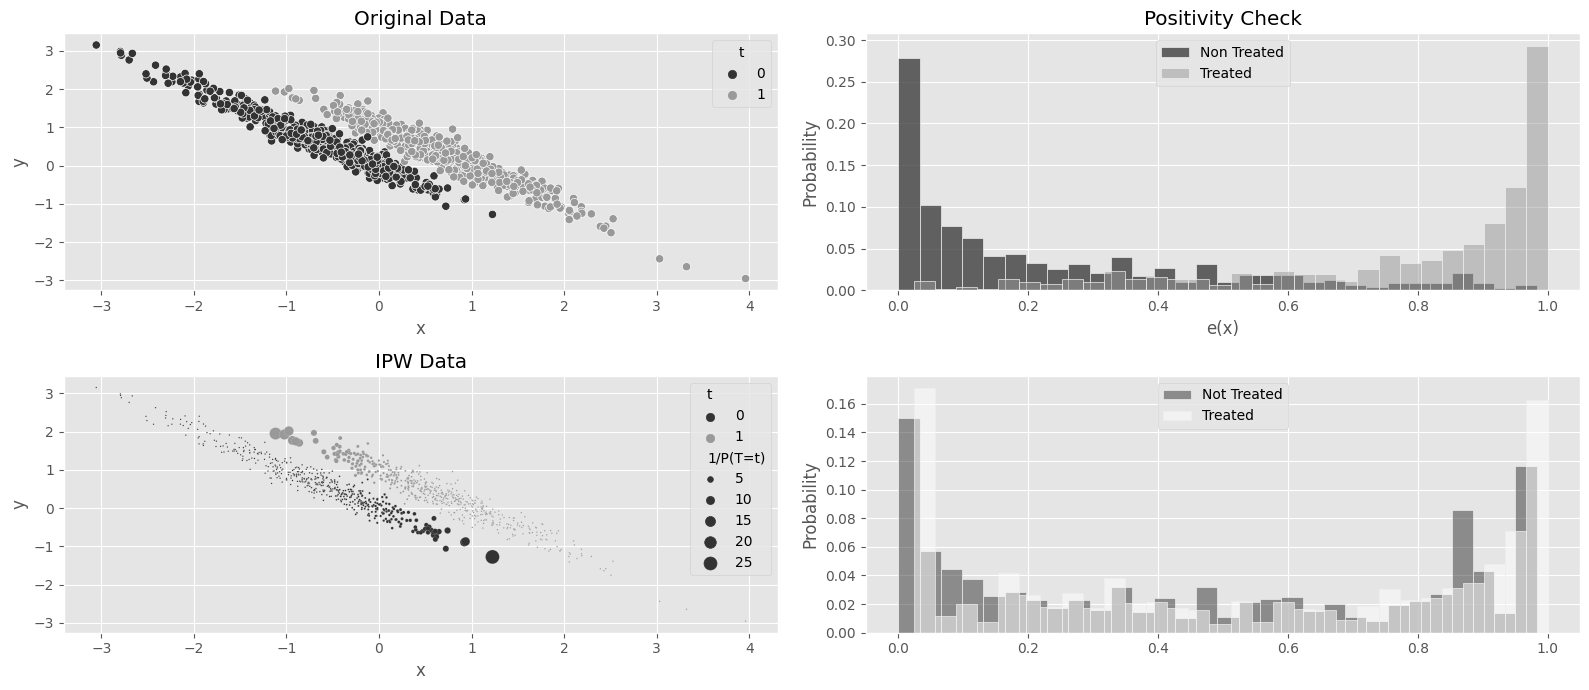

In [26]:
ps_model_sim = smf.logit("t ~ x", data=df_no_pos).fit(disp=0)           # initialize model for P(T=1|X)
df_no_pos_ps = df_no_pos.assign(ps=ps_model_sim.predict(df_no_pos))     # predict P(T=1|X), propensity

ps = ps_model_sim.predict(df_no_pos)            # predict P(T=1|X), propensity
w = df_no_pos["t"]*df_no_pos["t"].mean()/ps + (1-df_no_pos["t"])*((1-df_no_pos["t"].mean())/(1-ps)) #stabilized

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(16,7))

sns.scatterplot(data=df_no_pos_ps.assign(w=w), x="x", y="y", hue="t", ax=ax1)
ax1.set_title("Original Data")

sns.histplot(df_no_pos_ps.query("t==0")["ps"], stat="probability",
            label="Non Treated", color="C0", bins=30, ax=ax2)
sns.histplot(df_no_pos_ps.query("t==1")["ps"], stat="probability", 
            label="Treated", color="C1", alpha=0.5, bins=30, ax=ax2)
ax2.set_xlabel("e(x)")
ax2.legend()
ax2.set_title("Positivity Check")

sns.scatterplot(data=df_no_pos_ps.assign(**{"1/P(T=t)":w}), x="x", y="y", hue="t", ax=ax3, 
                size="1/P(T=t)", sizes=(1,100))
ax3.set_title("IPW Data")

df_no_pos_ps_sb = df_no_pos_ps.assign(**{"1/P(T=t)":w})
sns.histplot(df_no_pos_ps_sb.query("t==0"), 
            x=ps, stat="probability", weights=df_no_pos_ps_sb.query("t==0")["1/P(T=t)"],
            label="Not Treated", color="C0", bins=30, ax=ax4, alpha=0.5)


sns.histplot(df_no_pos_ps_sb.query("t==1"), 
            x=ps, stat="probability", weights=df_no_pos_ps_sb.query("t==1")["1/P(T=t)"],
            label="Treated", color="C2", bins=30, ax=ax4, alpha=0.5)
ax4.legend()



plt.tight_layout()

In [27]:
# ipw estimate
est_fn = partial(est_ate_with_ps, ps_formula="x", T="t", Y="y")
print("ATE: ", est_fn(df_no_pos))
print(f"95% C.I.: ", bootstrap(df_no_pos, est_fn))

ATE:  0.6478011810615735
95% C.I.:  [0.41710504 0.88840195]


In [28]:
# comparing linear regression to ipw
smf.ols("y ~ x + t", data=df_no_pos).fit().params["t"]

1.0165855487679474

#### Design - Versus Model-Based Identification

Techniques for debiasing nonexperimental data fall into two categories: model-based versus design-based identification. Model-based identification involves making assumptions, in the form of a model, of the potential outcomes conditioned on the treatment and additional covariates. The goal is to impute missing potential outcomes required for estimation ($E[Y_t|X]$). Design-based identification involves making assumptions about the treatment assignment mechanism ($P[T|X]$). 

From the perspective of orthogonalization, regression is design-based; from the perspective of an estimator for the potential outcome model, regression is model-based. IPW is purely design-based. Synthetic Control is purely model-based. The choice between model-based and design-based comes down to which type of assumption one is more comfortable with.

#### Doubly Robust Estimation

Doubly robust (DR) estimation is a way of combining both model- and design-based identification, hoping that at least one of them is correct. For example, combining linear regression and propensity score in a way that only one of them needs to be rightly specified. A doubly robust estimator for the counterfactual $Y_t$ is:

$\hat \mu _t ^{DR}(\hat m, \hat e) = \frac{1}{N} \Sigma \hat m (X) + \frac{1}{N}\Sigma [\frac{T}{\hat e(X)}(Y-\hat m(X))]$

where $\hat m(X)$ is an outcome model for $E[Y_t|X]$ such as linear regression, and $\hat e(X)$ is a propensity score model for $P(T|X)$. If the outcome model $\hat m(X)$ is correct but the propensity score model is incorrect, the second term would converge to zero, since $Y = \hat m(X)$ and $E[Y - \hat m(X)]=0$. You will be left with the first model, which is correct.

Say the outcome model is incorrect, but the propensity score model is accurate. After some algebraic manipulation, the preceding formula becomes:

$\hat \mu _t ^{DR}(\hat m, \hat e) = \frac{1}{N} \Sigma \frac{TY}{\hat e(X)} + \frac{1}{N}\Sigma [\frac{T - \hat e(X) }{\hat e(X)}\hat m(X)]$

If the propensity model is correct, $T-\hat e(X)$, would converge to zero, leaving only the first term, which is the IPW estimator. That is the doubly robust estimator converges to whichever model is correct. The doubly robust estimator estimates the average counterfactual outcome $Y_t$. To estimate the average treatment effect, put two of those estimators together, one for $E[Y_0]$ and one for $E[Y_1]$ and take the difference.

$ATE=\hat \mu _1 ^{DR} (\hat m, \hat e) - \hat \mu _0 ^{DR} (\hat m, \hat e)$

In [29]:
from sklearn.linear_model import LinearRegression 

def doubly_robust(df, formula, T, Y):   # T=treatment column name, Y=output column name
    X = dmatrix(formula, df)            # engineer covariate numpy matrix with patsy's dmatrix from formula

   
    ps_model = LogisticRegression(penalty=None, max_iter=1000).fit(X, df[T])     # propensity score model

    ps = ps_model.predict_proba(X)[:,1]     # predict propensity scores; store P(T=1|X); P(T=0|X) = 1 - P(T=1|X)

    m0 = LinearRegression().fit(X[df[T]==0,:], df.query(f"{T}==0")[Y])  # potential outcome model for Y_1 
    m1 = LinearRegression().fit(X[df[T]==1,:], df.query(f"{T}==1")[Y])  # potential outcome model for Y_0 

    m0_hat = m0.predict(X)      # predict potential outcome Y_1 for all samples
    m1_hat = m1.predict(X)      # predict potential outcome Y_0 for all samples

    return (
        np.mean(m1_hat + df[T]*(df[Y] - m1_hat)/ps) -               # E[Y_1] 
        np.mean(m0_hat + (1-df[T])*(df[Y] - m0_hat)/(1-ps))        # E[Y_0] note (1-df[T]) and (1-ps)
    )   # ATE = E[Y_1] - E[Y_0]

In [30]:
formuala = """tenure + last_engagement_score + department_score + C(n_of_reports)
            + C(gender) + C(role)"""
T = "intervention"
Y = "engagement_score"

print("Doubly Robust ATE : ", doubly_robust(df, formula, T, Y))

est_fn = partial(doubly_robust, formula=formula, T=T, Y=Y)
print("95% confidence interval :", bootstrap(df, est_fn))

Doubly Robust ATE :  0.2711545411906764
95% confidence interval : [0.23014098 0.30524714]


#### Treatment Is Easy to Model

Say we have an example where the treatment assignment is fairly easy to model, but the outcome model is a bit more complicated. Say the treatment follows a Bernoulli distribution with probability given by the following propensity score (look closely its exactly the same as a logistic regression): 

$e(x)=\frac{1}{1 + e^{-(1+1.5x)}}$

Since $P(T|X)$ is easy to model, IPW score should have no problem finding the true ATE, which is close to 2. One the other hand, since outcome Y is a bit trickier, a regression model might struggle.

In [31]:
np.random.seed(123)

n = 10000
x = np.random.beta(1,1,n).round(2)*2        # covariate
e = 1/(1+np.exp(-(1+1.5*x)))                # propensity score P(T|X)
t = np.random.binomial(1,e)                 # binom(n,p) p=propensity score

y1 = 1                                      # potential outcome if treated
y0 = 1 - 1*x**3                             # potential outcome if untreated (control)
y  = t*(y1) + (1-t)*y0 + np.random.normal(0,1,n)        # observed outcome

df_easy_t = pd.DataFrame(dict(y=y, x=x, t=t))
print("True ATE: ", np.mean(y1-y0))

True ATE:  2.0056243152


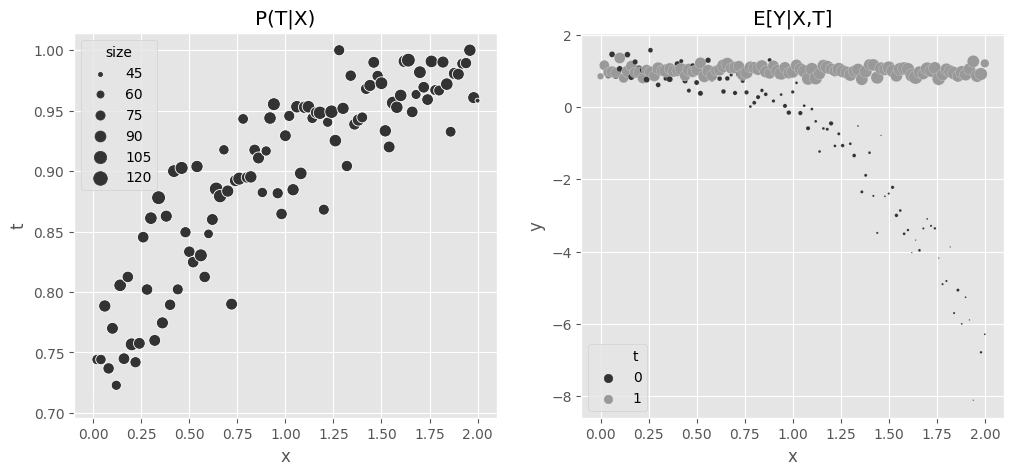

In [32]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot(data=(df_easy_t
                      .assign(size=1)
                      .groupby(["x"])
                      .agg({"size": "sum", "t": "mean"})    # number of covariate, treatment rate (probability)
                      .reset_index()),
                x="x", y="t", sizes=(1,100), size="size", ax=ax1) # covariate, treatment rate, size of cov
ax1.set_title("P(T|X)")

sns.scatterplot(data=(df_easy_t
                      .assign(size=1)
                      .groupby(["x", "t"])
                      .agg({"size": "sum", "y": "mean"})     # average outcome 
                      .reset_index()),
                x="x", y="y", hue="t",                # covariate, outcome, for each treatment
                sizes=(1,100), size="size", ax=ax2)   # size of covariate
ax2.set_title("E[Y|X,T]")

h, l = ax2.get_legend_handles_labels()
plt.legend(h[0:3], l[0:3])

In [33]:
# Using regression to model potential outcomes
m0 = smf.ols("y~x", data=df_easy_t.query("t==0")).fit()
m1 = smf.ols("y~x", data=df_easy_t.query("t==1")).fit()
regr_ate = (m1.predict(df_easy_t) - m0.predict(df_easy_t)).mean() # ate is the average change
print("Regression ATE: ", regr_ate)

Regression ATE:  1.78667839683302


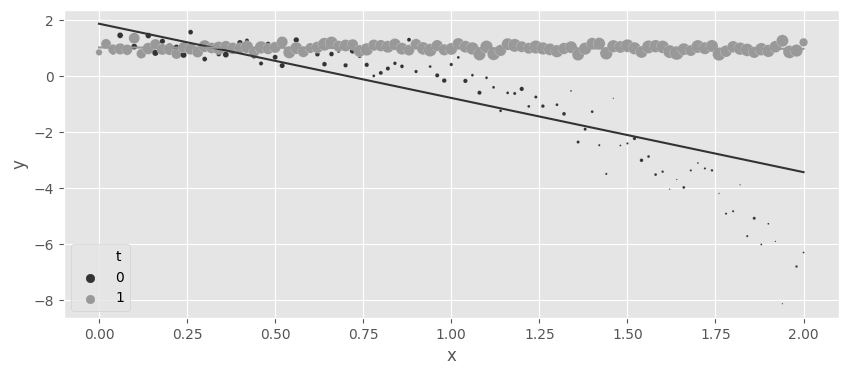

In [34]:
regr = smf.ols("y~x*t", data=df_easy_t).fit()

plt.figure(figsize=(10,4))

sns.scatterplot(data=(df_easy_t
                      .assign(count=1)
                      .groupby(["x", "t"])
                      .agg({"count": "sum", "y": "mean"})
                      .reset_index()),
                x="x", y="y", hue="t", sizes=(1,100), size="count") # covariate vs outcome for each treatment

g = sns.lineplot(data=(df_easy_t
                      .assign(pred=regr.fittedvalues)
                      .groupby(["x", "t"])
                      .mean()
                      .reset_index()),
                  x="x", y="pred", hue="t", sizes=(1,100)) # covariate vs outcome prediction

h, l = g.get_legend_handles_labels()
plt.legend(h[0:3], l[0:3])

In [35]:
# If we know the true curvature of the data, we could model it correctly with regression
m = smf.ols("y~t*(x + np.power(x,3))", data=df_easy_t).fit()
regr_ate = (m.predict(df_easy_t.assign(t=1)) - m.predict(df_easy_t.assign(t=0))).mean()
print("Regression ATE: ", regr_ate)

Regression ATE:  1.997099974718993


In [36]:
# compare with IPW
est_fn = partial(est_ate_with_ps, ps_formula="x", T="t", Y="y")
print("Propensity Score ATE:", est_fn(df_easy_t))
print("95% CI", bootstrap(df_easy_t, est_fn))

Propensity Score ATE: 2.002350388474011
95% CI [1.80802227 2.22565667]


In [37]:
# compare with DR
est_fn = partial(doubly_robust, formula="x", T="t", Y="y")
print("DR ATE:", est_fn(df_easy_t))
print("95% CI", bootstrap(df_easy_t, est_fn)) # the confidence interval is closer in DR than in

DR ATE: 2.001617934263116
95% CI [1.87088771 2.145382  ]


#### Outcome Is Easy to Model

This time the nonlinearity is in $P(T|X)$, while the outcome function $E[Y_t|X]$ is simply linear. Since the propensity score is relatively complex to model, IPW does not manage to recover the true ATE, but regression manages to get it precisely right. Once again, because DR only needs one of the models to be correctly specified,it also manages to recover the true ATE here.

In [38]:
np.random.seed(123)

n = 10000
x = np.random.beta(1,1,n).round(2)*2
e = 1/(1+np.exp(-(2*x - x**3)))
t = np.random.binomial(1,e)

y1 = x 
y0 = y1 + 1  # ate of -1 

y = t*(y1) + (1-t)*y0 + np.random.normal(0,1,n)

df_easy_y = pd.DataFrame(dict(y=y, x=x, t=t))
print("True ATE: ", np.mean(y1-y0))

True ATE:  -1.0


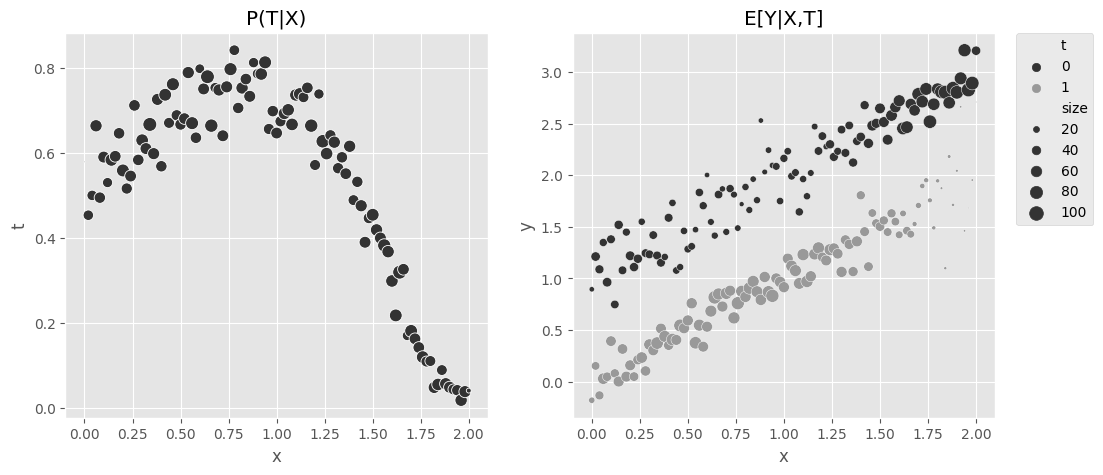

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot(data=(df_easy_y
                      .assign(size=1)
                      .groupby(["x"])
                      .agg({"size": "sum", "t": "mean"})    # number of covariate, treatment rate (probability)
                      .reset_index()),
                x="x", y="t", sizes=(1,100), legend=None,
                size="size", ax=ax1) # covariate, treatment rate, size of cov
ax1.set_title("P(T|X)")

sns.scatterplot(data=(df_easy_y
                      .assign(size=1)
                      .groupby(["x", "t"])
                      .agg({"size": "sum", "y": "mean"})    
                      .reset_index()),
                x="x", y="y", hue="t",                # covariate, outcome, for each treatment
                sizes=(1,100), size="size", ax=ax2)   # size of covariate
ax2.set_title("E[Y|X,T]")


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [43]:
# ATE determination with IPW
est_fn = partial(est_ate_with_ps, ps_formula="x", T="t", Y="y") # partial allows specifying formula, T, Y first
print("Propensity Score ATE: ", est_fn(df_easy_y))              # partial allows df later
print("95% CI ", bootstrap(df_easy_y, est_fn))

Propensity Score ATE:  -1.1042900278680894
95% CI  [-1.14326893 -1.06576358]


In [44]:
# ATE estimation with regression
m0 = smf.ols("y~x", data=df_easy_y.query("t==0")).fit()
m1 = smf.ols("y~x", data=df_easy_y.query("t==1")).fit()
regr_ate = (m1.predict(df_easy_y) - m0.predict(df_easy_y)).mean()
print("Regression ATE:", regr_ate)

Regression ATE: -1.0008783612504364


In [45]:
# ATE estimation with DR
est_fn = partial(doubly_robust, formula="x", T="t", Y="y")
print("DR ATE: ", est_fn(df_easy_y))
print("95% CI", bootstrap(df_easy_y, est_fn))

DR ATE:  -1.002845934780583
95% CI [-1.04156952 -0.96353366]


#### Generalized Propensity Score for Continuous Treatment

Estimating continuous treatment with OLS is straight forward, by assuming a functional form for the treatment response, like $y=a+bt$ (linear form) or $y=a+b\sqrt t$ (square root form). But when it comes to propensity weighting, there is no such thing as a parametric response function. The potential outcomes are estimated nonparametrically, ie by reweighting and taking averages. When T is continuous, there exist infinitely many potential outcomes $Y_t$. Also since the probability of a continuous variable is always zero, it is not feasible to estimate P(T=t|X).

One way out is to discretize the continuous treatment into a coarser version that can be treated as discrete. Another way is to use the generalized propensity score, which is designed to accomodate any type of treatment.

Below is a case study where a bank wants to know how a loan's interest rates affect the duration (in months) that a customer chooses to pay back that loan. The effect of interest on duration should be negative, since people pay back high-rate loas as fast as possible to avoid paying too much on interest. The bank could randomize the interest rate, but that would be costly. Instead the bank wants to use data it already has. The bank knows that interest loans were assigned by two machine learning models ml_1 and ml_2. The bank's data scientists added random Gaussian noise to the interest rate decision-making process to ensure that the policy was nondeterministic and that the positivity assumption is not violated. 

In [46]:
df_cont_t = pd.read_csv("data/interest_rate.csv")
df_cont_t.head()

,ml_1,ml_2,interest,duration
0,0.392938,0.326285,7.1,12.0
1,-0.427721,0.679573,5.6,17.0
2,-0.546297,0.647309,11.1,12.0
3,0.102630,-0.264776,7.2,18.0
4,0.438938,-0.648818,9.5,19.0


In [47]:
# naive treatment effect, without adjusting for anything
m_naive = smf.ols("duration ~ interest", data=df_cont_t).fit()
m_naive.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,14.5033,0.226,64.283,0.000,14.061,14.946
interest,0.3393,0.029,11.697,0.000,0.282,0.396


In [48]:
# linear regression treatment effect,  adjusting for ml_1 and ml_2
m_naive = smf.ols("duration ~ interest + ml_1 + ml_2", data=df_cont_t).fit()
m_naive.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,23.0205,0.041,566.418,0.000,22.941,23.100
interest,-0.8000,0.005,-152.313,0.000,-0.810,-0.790
ml_1,-8.0209,0.019,-428.940,0.000,-8.058,-7.984
ml_2,-8.0165,0.019,-426.432,0.000,-8.053,-7.980


In order to use reweighting, a first problem is that continous variables have a probability of zero everywhere, ie $P(T=t)=0$. This is because, probability is represented by the area under the density  and the area of a single point is always zero. One possibility is to work with the conditional density function $f(T|X)$ instead of the conditional probability $P(T=t|X)$. This approach brings up the issue of having to specify the distribution of the treatment. 

Suppose we assume its drawn from a normal distribution $T$~$N(\mu _i, \sigma ^2)$, and a constant variance $\sigma ^2$, and a mean that changes for each individual $\mu _i$. The density of the normal distribution is:

$f(t_i) = \frac{exp(\frac{-1}{2}(\frac{t_i-\mu_i}{\sigma})^2)}{\sigma \sqrt {2 \pi}}$

Now to estimate the mean and standard deviation of this conditional Gaussian density, we can use OLS to fit the treatment variable. The fitted values (OLS prediction) will be individual mean $\mu _i$ and the standard deviation of the residual will be the constant standard deviation , $\sigma$. This will form an estimate for the conditional density. 

Next, evaluate that conditional density at the given treatment. We could write our own code or import the normal distribution from scipy and use that instead. Suppose the treatment follows another distribution other than the normal distribution, you can use generalized linear models (glm) to fit it. The conditional density values at each individual sample can then be inverted to get the weights. And because the treatment is continuous we would use these weights in a linear regression to adjust for the bias.

In [49]:
model_t = smf.ols("interest ~ ml_1 + ml_2", data=df_cont_t).fit() # model treatment using linear regression

In [50]:
def conditional_density(x, mean, std):
    denom = std * np.sqrt(2*np.pi)              # denominator of density function for normal distribution
    num = np.exp(-((1/2)*((x-mean)/std)**2))    # density of normal distribution
    return (num/denom).ravel()                  # mean is a list of values, so ravel final

gps = conditional_density(df_cont_t["interest"],    # actual interest value for individual's distribution
                          model_t.fittedvalues,     # model prediction as mean for individual's distribution
                          np.std(model_t.resid)     # constant variance for each individual's distribution
                          )

gps

array([0.1989118 , 0.14524168, 0.03338421, ..., 0.07339096, 0.19365006,
       0.15732008])

In [59]:
# Assuming the treatment was assigned according to Poisson
import statsmodels.api as sm
from scipy.stats import poisson 

mt = smf.glm("interest ~ ml_1 + ml_2", data=df_cont_t, 
             family=sm.families.Poisson()).fit()      # model the treatment using generalized linear model
gps = poisson(mu=mt.fittedvalues).pmf(df_cont_t['interest'])
gps

array([0.        , 0.        , 0.        , ..., 0.        , 0.12958752,
       0.        ])

In [60]:
# Using scipy for the normal distribution
from scipy.stats import norm 

gps = norm(loc=model_t.fittedvalues,    # each treatment prediction is its own mean; all std is residual std
           scale=np.std(model_t.resid)).pdf(df_cont_t["interest"]) # get the density values for the weights
gps

array([0.1989118 , 0.14524168, 0.03338421, ..., 0.07339096, 0.19365006,
       0.15732008])

In [62]:
w = 1/gps
w

array([ 5.02735371,  6.88507585, 29.95427936, ..., 13.62565629,
        5.16395398,  6.35646762])

In [64]:
# Using the inverse for weighted regression to estimate unbiased treatment effect
final_model = smf.wls("duration ~ interest", data=df_cont_t, weights=1/gps).fit() # weighted regression
final_model.params["interest"]

-0.6673977919925813

The density for any sample is calculated with a normal distribution centered on the ols / glm prediction. This means that samples with high residuals (deviation from prediction, the distribution mean) will have low density values (density is highest at the mean and tapers of with deviation from the mean in a normal distribution). Using this score to construct (inverse) weights will assign greater importance to points with unlikely treatments. Specifically, you will assign high weights with high residuals in the treatment model that is fitted. Additionally, due to the exponential nature of the normal density , the weights will increase exponentially with the size of the residual.

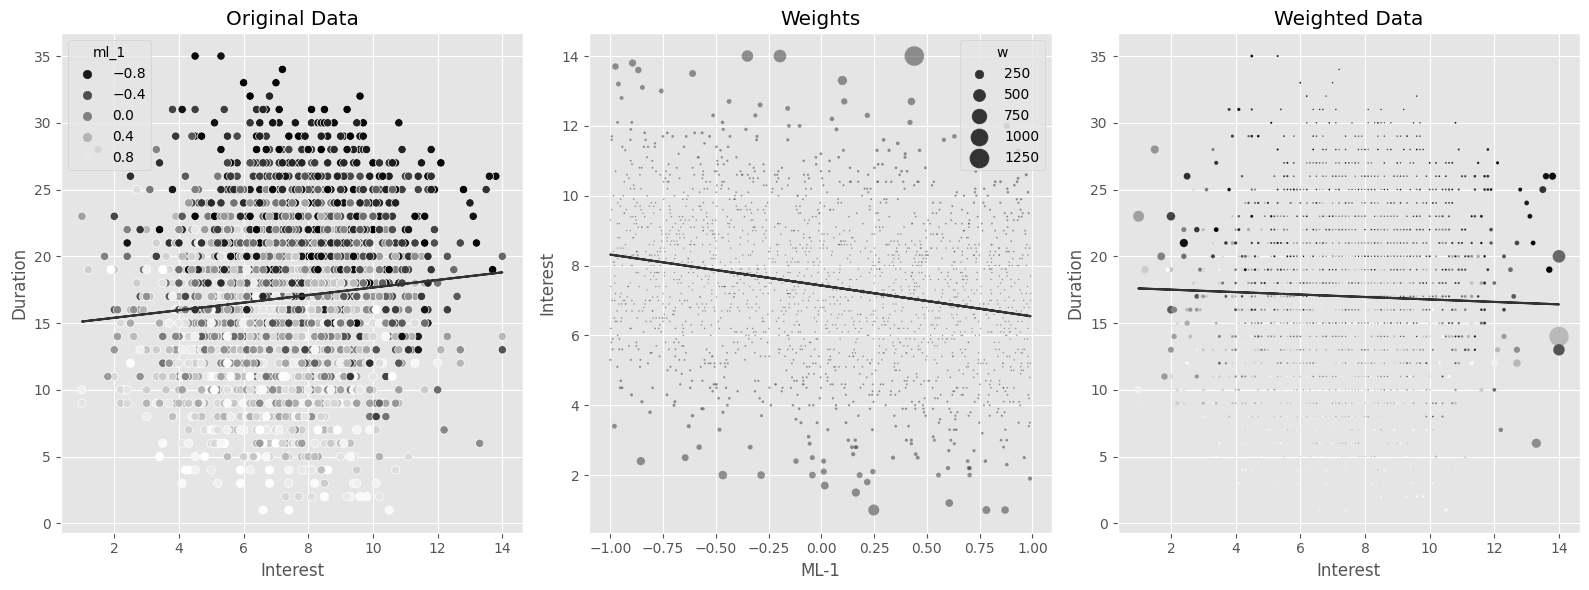

In [83]:
# Using only one covariate, ml_1 for visualization purposes
np.random.seed(1)
sample = df_cont_t.sample(2000)

model_ex = smf.ols("interest ~ ml_1", data=sample).fit() # treatment assignment model; T = f(X)
gps_ex = norm(loc=model_ex.fittedvalues,    # propensity scores; conditional probability density values pdf(T|X)
              scale=np.std(model_ex.resid)  # constant variance equal to variance of residuals
              ).pdf(sample["interest"])     # probability density value of each treatment value
w_ex = 1 / gps_ex                           # inverse propensity scores from inverse density values


m = smf.ols("duration ~ interest", data=sample).fit()   # unweighted outcome model Y = f(T)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,6))

# plot 1: unweighted outcome model
sns.scatterplot(data=sample, x="interest", 
                y="duration", alpha=1, ax=ax1, 
                hue="ml_1", palette="gray")    # scatterplot of treatment vs outcome, (hue is ml_1 values)
ax1.plot(sample["interest"], m.fittedvalues)   # line plot treatment vs outcome (unweighted outcome model)
ax1.set_ylabel("Duration")
ax1.set_xlabel("Interest")
ax1.set_title("Original Data")

# plot 2: treatment assignment model
sns.scatterplot(data=sample.assign(w=w_ex),         # add the inverse density weights to dataframe
                x="ml_1", y="interest", size="w",   # how the covariate predicts the assignment of treatment
                sizes=(1,200), alpha=0.5, ax=ax2)   # scatter plot covariate vs treatment (size = weights)
ax2.plot(sample["ml_1"], model_ex.fittedvalues) # line plot covariate vs treatment (treatment assignment model)
ax2.set_ylabel("Interest")
ax2.set_xlabel("ML-1")
ax2.set_title("Weights")

m = smf.wls("duration ~ interest", data=sample, weights=w_ex).fit() # weighted outcome model Y = f(T,w)

# plot 3: weighted outcome model
sns.scatterplot(data=sample.assign(w=w_ex), x="interest", 
                y="duration", size="w", sizes=(1,200), 
                alpha=1, ax=ax3, hue="ml_1", legend=None, 
                palette="gray")  # scatterplot of treatment vs outcome (size based on weights)
ax3.plot(sample["interest"], m.fittedvalues)    # line plot treatment vs outcome (weighted outcome model)
ax3.set_ylabel("Duration")
ax3.set_xlabel("Interest")
ax3.set_title("Weighted Data")

plt.tight_layout()

When we first plot the  treatment (interest) against the outcome (duration), we initially have a positive relationship, as evidenced by the positive trend. The biased relationship is modeled as linear regression model where all samples are unweighted (all weights equal 1). 

To obtain the propensity scores we need a treatment assignment model which we models the relationship between the confounding covariate (ml_1) and the treatment (interest). The propensity score is the probabilty density of each treatment value drawn from a normal distribution with a mean centered on the treatment assignment model's prediction for that sample and whose variance is the variance of the model's residuals. This represents the conditional probability density function values, $f(t|x)$. Once we have all the probability density function values, the inverse gives the inverse propensity weights (IPW). This gives larger weights to samples with larger residuals since these have the lower probability density function values. The second plot shows a plot of the confounding variable against the treatment including the treatment assignment model, and the weight assigned to individual samples. Clearly the points that are farthest away from the line have higher weights. 

Finally we can model the unbiased relationship between the interest and outcome, this time weighting the examples with the IPW values. The unbiased relationship is now negative. Again the treatment values that have the higher residual values from the treatment assignment model have the higher weights.

In [68]:
stabilizer = norm(  # density value for each treatment from dist
    loc=df_cont_t["interest"].mean(),   # distribution has mean of average treatment
    scale = np.std(df_cont_t["interest"] - df_cont_t["interest"].mean()) # dist std is std of demeaned treatment
).pdf(df_cont_t["interest"])  

gipw = stabilizer / gps             # stabilizes the propensity scores obtained with both ml_1 and ml_2
print("Original Sample Size:", len(df_cont_t))
print("Effective Stable Weights Sample Size:", sum(gipw))

Original Sample Size: 10000
Effective Stable Weights Sample Size: 9988.195951748605


In [72]:
final_model = smf.wls("duration ~ interest", data=df_cont_t, weights=gipw).fit() # weighted regression for ate
final_model.params["interest"]

-0.7787046278134059

To improve, stabilize the weights by the marginal density $f(t)$. To estimate $f(t)$, simply use the average treatment value, and the variance is the variance of the residuals obtained from subtracting the average treatment value from each individual interest value. Essentially, we are modeling normal distribution functions where the prediction for each treatment is the average treatment value, then evaluate the resulting density at the given treatments. This stabilization produces weights that sum to (almost) the original sample size. In terms of importance sampling, these weights take you from $f(t|x)$ to $f(t)$, a density where the treatment does not depend on $x$.

Each treatment is compared to two values; the fitted values (inverse propensity weighting) and the average treatment value (stabilization). From these two values, a density is calculated for each treatment but only one density value is inverted. Inverse propensity weighting gives high importance to points that are far from the fitted values of the treatment model, as they fall in a low-density region of $f(t|x)$. Additionally, the stabilization also gives low importance to points that are far way from f(t), that is points far from the mean, since stabilization density values are not inverted . The result is twofold. First, stabilized weights are much smaller, which gives lower variance. Secondly, in the example used, it becomes clear that you are now giving more importance to points with both low values ml_1 (confounding covariate) and low interest rates (treatment). Weight stabilization is even more relevant for continuous treatments than for discrete treatments (where it mostly serves to control computation issues). Stabilization for continuous treatments get you closer to the true value of the parameter you are trying to estimate and it also significantly reduces the variance.

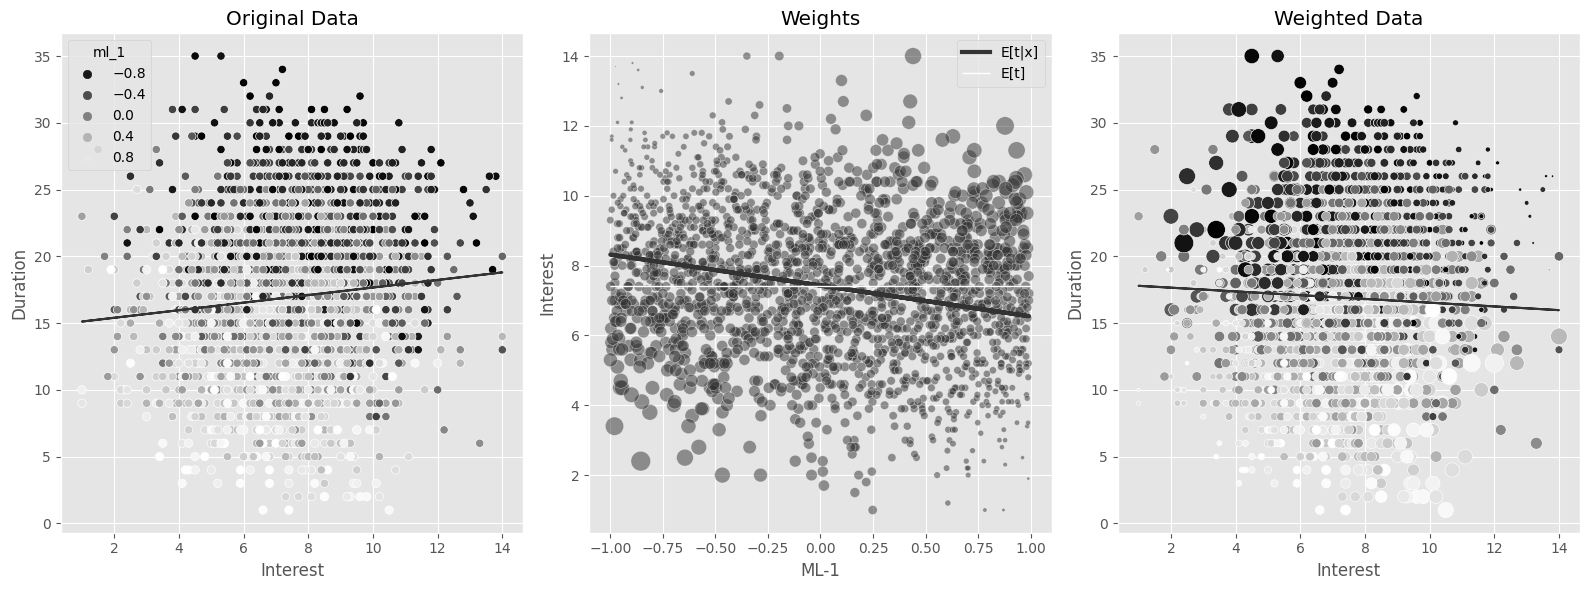

In [86]:
# Using only one covariate, ml_1 for visualization purposes
np.random.seed(1)
sample = df_cont_t.sample(2000)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,6))

model_ex = smf.ols("interest ~ ml_1", data=sample).fit() # treatment assignment model; T = f(X)
gps_ex = norm(loc=model_ex.fittedvalues,    # propensity scores; conditional probability density values pdf(T|X)
              scale=np.std(model_ex.resid)  # constant variance equal to variance of residuals
              ).pdf(sample["interest"])     # probability density value of each treatment value from its dist

stabilizer = norm(
    loc=sample["interest"].mean(),  # mean is the average treatment
    scale = np.std(sample["interest"] - sample["interest"].mean()) # std is the std of demeaned treatment
).pdf(sample["interest"])   # pdf values for each treatment value from stabilizer distribution


w_ex = stabilizer / gps_ex                        # stabilized inverse propensity scores


m = smf.ols("duration ~ interest", data=sample).fit()   # unweighted outcome model Y = f(T)


# plot 1: unweighted outcome model
sns.scatterplot(data=sample, x="interest", 
                y="duration", alpha=1, ax=ax1, 
                hue="ml_1", palette="gray")    # scatterplot of treatment vs outcome, (hue is ml_1 values)
ax1.plot(sample["interest"], m.fittedvalues)   # line plot treatment vs outcome (unweighted outcome model)
ax1.set_ylabel("Duration")
ax1.set_xlabel("Interest")
ax1.set_title("Original Data")

# plot 2: treatment assignment model
sns.scatterplot(data=sample.assign(w=w_ex), 
                x="ml_1", y="interest", size="w", 
                sizes=(1,200), alpha=0.5, ax=ax2)   # scatter plot covariate vs treatment (size = weights)
ax2.plot(sample["ml_1"], model_ex.fittedvalues,
         label="E[t|x]", lw=3) # line plot covariate vs treatment (treatment assignment model)
ax2.hlines(sample["interest"].mean(), -1, 1, label="E[t]", color="C2", lw=1) # average treatment value
ax2.set_ylabel("Interest")
ax2.set_xlabel("ML-1")
ax2.set_title("Weights")

h, l = ax2.get_legend_handles_labels()
ax2.legend(h[5:], l[5:])

m = smf.wls("duration ~ interest", data=sample, weights=w_ex).fit() # weighted outcome model Y = f(T,w)

# plot 3: weighted outcome model
sns.scatterplot(data=sample.assign(w=w_ex), x="interest", 
                y="duration", size="w", sizes=(1,200), 
                alpha=1, ax=ax3, hue="ml_1", legend=None, 
                palette="gray")  # scatterplot of treatment vs outcome (size based on weights)
ax3.plot(sample["interest"], m.fittedvalues)    # line plot treatment vs outcome (weighted outcome model)
ax3.set_ylabel("Duration")
ax3.set_xlabel("Interest")
ax3.set_title("Weighted Data")

plt.tight_layout()

In [92]:
# code for generalized modeling of continuous treatment with inverse propensity weighting
def gps_normal_ate(df, formula, T, Y, stable=True):
    mt = smf.ols(f"{T} ~" + formula, data=df).fit()
    gps = norm(loc=mt.fittedvalues, scale=np.std(mt.resid)).pdf(df[T])
    stabilizer = norm(
        loc=df[T].mean(),
        scale=np.std(df[T] - df[T].mean())
    ).pdf(df[T])

    if stable:
        return smf.wls(f"{Y}~{T}", data=df, weights=stabilizer/gps).fit().params[T]
    else:
        return smf.wls(f"{Y}~{T}", data=df, weights=1/gps).fit().params[T]
    
print("95% CI, non-stable: ", bootstrap(df_cont_t, 
                                        partial(gps_normal_ate, formula="ml_1 + ml_2", T="interest",
                                                Y="duration",stable=False)))

print("95% CI stable: ", bootstrap(df_cont_t, 
                                   partial(gps_normal_ate, formula="ml_1 + ml_2", T="interest", Y="duration")))

95% CI, non-stable:  [-0.81074164 -0.52605933]
95% CI stable:  [-0.85834311 -0.71001914]


#### Regression vers Inverse Propensity Weighting

Regression (via orthogonalization) and inverse propensity weighting are two main techniques so far for bias adjustment. Both require that the treatment assignment be modeled. Each technique uses the treatment model in different ways. Orthogonalization residualizes the treatment to be linearly independent of the covariates used to model the treatment assignment. Inverse propensity weighting reweights the data using the inverse propensity score to create a pseudo population where the treatment does not depend on the covariates that were used to build the propensity model. Thus orthogonalization and inverse propensity weighting debias the data using two distinct ideas. If the treatment is discrete, the clearest way is to use inverse propensity weighting especially if paired with regression in a doubly robust estimation model. If treatment is continuous, regression is the clearest approach.